<a href="https://colab.research.google.com/github/wastb/KIAM-Week6/blob/master/notebooks/Credit_Scoring_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Objectives***

*The primary objectives of this project are as follows:*

- *Develop a Credit Risk Model: Build and train machine learning models that assign risk probabilities to new customers based on historical transaction data.*

- *Credit Scoring: Use the model's probability estimates to create a credit score for each customer, facilitating quick and accurate creditworthiness assessments.*

- *Loan Optimization: Predict the optimal loan amount and duration for new customers, considering their risk profile to ensure sustainable lending practices*


In [2]:
## import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Google Colab Folder/woe_data.csv')
df.head()

,Transaction_Day,Monetary,Frequency,Average_Transaction_Value,Transaction_Year_woe,Transaction_Month_woe,Value,Transaction_Day_woe,Recency,Transaction_Hour,Transaction_Month,Average_Transaction_Value_woe,Transaction_Hour_woe,Stability,Value_woe,Transaction_Year,RFMS_Score,BAD
0,15,0.026998,0.028851,1553.336134,0.820147,-0.267679,1000.0,0.125989,1.0,2,11,0.059461,0.049337,0.277278,0.105123,2018,0.333282,0
1,15,0.026998,0.028851,1553.336134,0.820147,-0.267679,20.0,0.125989,1.0,2,11,0.059461,0.049337,0.277278,0.105123,2018,0.333282,0
2,15,0.000139,0.000244,500.000000,0.820147,-0.267679,500.0,0.125989,1.0,2,11,-6.279989,0.049337,0.000000,0.105123,2018,0.250096,1
3,15,0.017162,0.009046,3092.710526,0.820147,-0.267679,1000.0,0.125989,1.0,3,11,0.059461,0.049337,0.483036,0.105123,2018,0.377311,0
4,15,0.017162,0.009046,3092.710526,0.820147,-0.267679,644.0,0.125989,1.0,3,11,0.059461,0.049337,0.483036,0.105123,2018,0.377311,0


In [5]:
## Define Features and Target Variable
X = df.drop(columns='BAD')
y = df['BAD']

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### ***Balancing Imbalanced Data***

In [7]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances the classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_train_smote.value_counts()}")

Before SMOTE: BAD
1    59475
0    17054
Name: count, dtype: int64
After SMOTE: BAD
1    59475
0    59475
Name: count, dtype: int64


In [8]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

In [9]:
## Display the size of the train and test sets
print(f"Training set size: {X_train_scaled.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 118950 samples
Testing set size: 19133 samples


In [10]:
# Define a function to evaluate the model performance
def evaluate_model(y_true, y_preds, y_proba, model_name):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    roc_auc = roc_auc_score(y_true, y_preds)

    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_preds)}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_preds)
    print(f"Confusion Matrix:\n{cm}\n")
    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

#### ***Model Selection and Training***

#### ***1. Logistic Regression***

In [17]:
# Initialize the model
log_reg = LogisticRegression()
param_grid = [
    {'penalty':['l1','l2'],
    'C' : np.logspace(-4,4,3),
    'solver': ['liblinear','saga'],
    'max_iter'  : [100,1000,2000]
}
]
clf = GridSearchCV(log_reg, param_grid = param_grid, cv = 3, verbose=True,n_jobs=-1)

In [18]:
# Train Logistic Regression
best_clf = clf.fit(X_train_scaled, y_train_smote)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [19]:
# Get the best estimator (model)
best_log_reg = best_clf.best_estimator_

# Make predictions with the best model
y_pred_lg = best_log_reg.predict(X_test)
y_prob_lg = best_log_reg.predict_proba(X_test)[:, 1]

#### ***Model Evaluation***

Logistic Regression Performance:
Accuracy: 0.9997
Precision: 0.9999
Recall: 0.9997
F1 Score: 0.9998
ROC-AUC: 0.9996
Confusion Matrix:
[[ 4274     2]
 [    4 14853]]

Confusion Matrix:
[[ 4274     2]
 [    4 14853]]



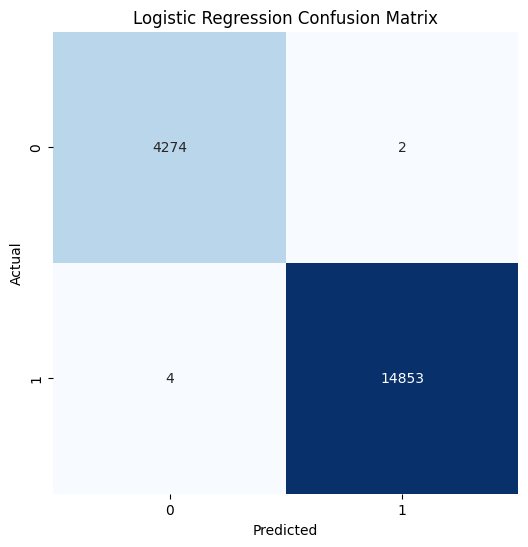

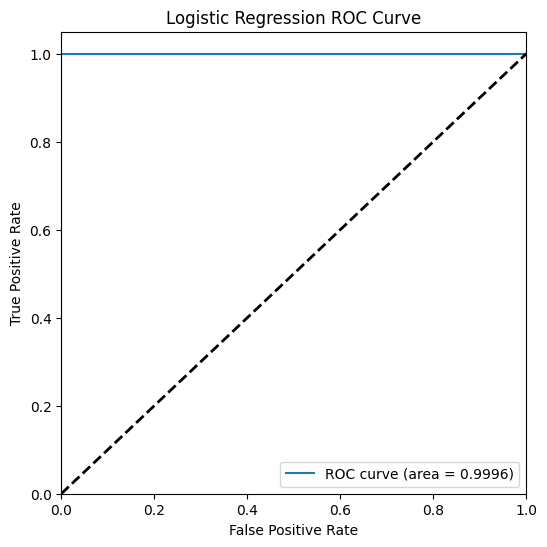

In [20]:
evaluate_model(y_test, y_pred_lg, y_prob_lg, "Logistic Regression")

#### ***Credit Scoring Using Logistic Regression***

In [25]:
# Function to map probabilities to credit score
def risk_to_credit_score(probability):
    min_score = 300
    max_score = 850
    return min_score + (max_score - min_score) * (1 - probability)  # Inverse of risk

# Apply function to risk probabilities
credit_scores = [risk_to_credit_score(prob) for prob in y_prob_lg]

# Show mapped credit scores
df_credit_scores = pd.DataFrame({'index': range(len(X_test)), 'RiskProbability': y_prob_lg, 'CreditScore': credit_scores})
print(df_credit_scores)


       index  RiskProbability  CreditScore
0          0              1.0        300.0
1          1              1.0        300.0
2          2              1.0        300.0
3          3              1.0        300.0
4          4              1.0        300.0
...      ...              ...          ...
19128  19128              1.0        300.0
19129  19129              1.0        300.0
19130  19130              1.0        300.0
19131  19131              1.0        300.0
19132  19132              1.0        300.0

[19133 rows x 3 columns]


In [38]:
# Save the trained model
joblib.dump(best_log_reg, 'Logistic_Regression_model.pkl')

['Logistic_Regression_model.pkl']

#### ***2. Random Forest Classifier***

In [29]:
## Initialize the model
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100],
    'max_features': ['sqrt', 'log2']
}

## Grid search parameter tuning
grid_search = GridSearchCV(rf, param_grid=param_grid,cv = 3, verbose=True, n_jobs=-1)

In [30]:
# Train Logistic Regression
best_rf = grid_search.fit(X_train_scaled, y_train_smote)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [34]:
# Get the best estimator (model)
best_rf_classifier = best_rf.best_estimator_

# Make predictions with the best model
y_pred_rf = best_rf_classifier.predict(X_test)
y_prob_rf = best_rf_classifier.predict_proba(X_test)[:, 1]

#### ***Model Evaluation***

Random Forest Classifier Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000
Confusion Matrix:
[[ 4276     0]
 [    0 14857]]

Confusion Matrix:
[[ 4276     0]
 [    0 14857]]



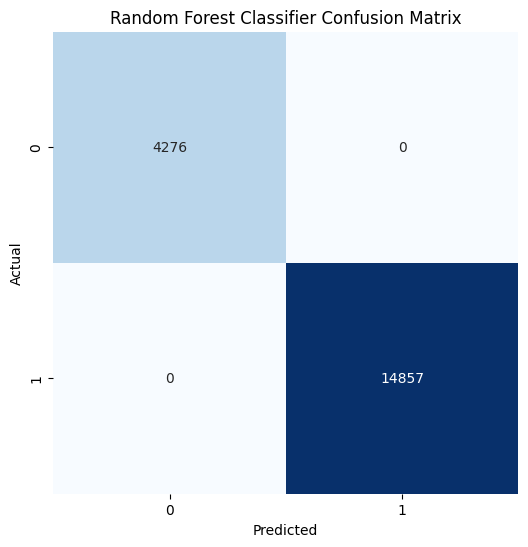

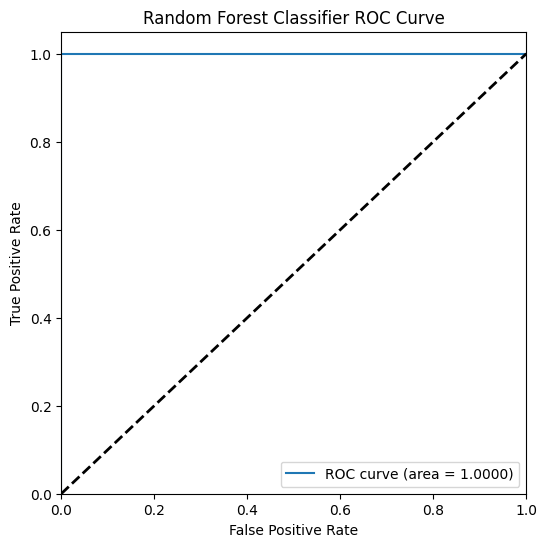

In [35]:
## Use the above defined function
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest Classifier")

#### ***Credit Scoring Using Random Forest Classifier***

In [36]:
# Show mapped credit scores
df_credit_scores_rf = pd.DataFrame({'index': range(len(X_test)), 'RiskProbability': y_prob_rf, 'CreditScore': credit_scores})
print(df_credit_scores_rf)

       index  RiskProbability  CreditScore
0          0              1.0        300.0
1          1              1.0        300.0
2          2              1.0        300.0
3          3              1.0        300.0
4          4              1.0        300.0
...      ...              ...          ...
19128  19128              1.0        300.0
19129  19129              1.0        300.0
19130  19130              1.0        300.0
19131  19131              1.0        300.0
19132  19132              1.0        300.0

[19133 rows x 3 columns]


In [37]:
import joblib

# Save the trained model
joblib.dump(best_rf_classifier, 'random_forest_model.pkl')

['random_forest_model.pkl']